<!DOCTYPE html>
<html>
<head>
<style>
    .header-banner {
        background-color: white;
        color: black; 
        padding: 1rem; 
        font-family: 'Nunito', sans-serif;
    }
    .header-content {
        max-width: 2000px;
        margin: 0 auto;
        display: flex;
        align-items: center;
        gap: 2rem;
    }
    .logo {
        max-width: 160px;
    }
    .text-content {
        flex: 1;
    }
    .text-content h1 {
        font-size: 34px;
        margin: 0 0 10px;
        font-weight: 700;
        color: #7e4d02ff;
        border-bottom: 2px solid #e5c120ff;
        padding-bottom: 10px;
    }
    .text-content h2 {
        font-size: 21px;
        margin: 0 0 5px;
        font-weight: 600;
        color: #222;
    }
    .member-list {
        display: grid;
        grid-template-columns: repeat(2, auto);
        gap: 6px 40px;
        font-size: 17px;
        color: #444;
    }
    .member {
        position: relative;
        padding-left: 20px;
    }
</style>
<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Nunito:wght@400;700&display=swap" rel="stylesheet">
</head>
<body>

<header class="header-banner">
    <div class="header-content">
        <img src="https://i.ibb.co/JBPWVYR/Logo-Nova-IMS-Black.png" alt="NOVA IMS Logo" class="logo">
        <div class="text-content">
            <h1>Cars 4 You: Expediting Car Evaluations with ML</h1>
            <h2>Group 37</h2>
            <div class="member-list">
                <div class="member">Filipa Pereira, 20240509</div>
                <div class="member">Gonçalo Silva, 20250354</div>
                <div class="member">Marta La Feria, 20211051 </div>
                <div class="member">Tomás Coroa, 20250394 </div>
            </div>
        </div>
    </div>
</header>

</body>
</html>

### Import Libraries

In [68]:
#!pip install optuna-integration

In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import clone

# Feature Selection
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

# Models
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor

# Metrics and Utilities
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_pinball_loss
from sklearn.model_selection import ParameterGrid


from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
import optuna
import numpy as np

### Load Data

In [70]:
# Load the processed datasets (train, validation, test)
X_train = pd.read_parquet("./project_data/X_train_final.parquet", engine="pyarrow")
X_val   = pd.read_parquet("./project_data/X_val_final.parquet",   engine="pyarrow")
X_test  = pd.read_parquet("./project_data/X_test_final.parquet",  engine="pyarrow")

y_train_df = pd.read_parquet("./project_data/y_train.parquet", engine="pyarrow").squeeze("columns")
y_val_df   = pd.read_parquet("./project_data/y_val.parquet",   engine="pyarrow").squeeze("columns")

# Set 'carID' as the index for all sets
X_train.set_index('carID', inplace=True)
X_val.set_index('carID', inplace=True)
X_test.set_index('carID', inplace=True)

# Extract the target variable 'price' as a Series and ensure its index is 'carID'
y_train = y_train_df.set_index('carID')['price']
y_val = y_val_df.set_index('carID')['price']

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (60767, 35)
Shape of y_train: (60767,)
Shape of X_val: (15193, 35)
Shape of y_val: (15193,)
Shape of X_test: (32567, 35)


In [71]:
X_train.columns

Index(['mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%',
       'previousOwners', 'hasDamage', 'age', 'brand_mean_price',
       'brand_median_price', 'brand_price_std', 'brand_count',
       'mileage_per_year', 'high_mileage', 'low_mileage', 'age_squared',
       'is_new_car', 'is_old_car', 'mpg_per_liter', 'engine_power_indicator',
       'age_mileage_interaction', 'depreciation_score', 'tax_per_engine',
       'Brand_target_enc', 'brand_model_target_enc', 'transmission_manual',
       'transmission_other', 'transmission_semi auto', 'transmission_None',
       'fuelType_electric', 'fuelType_hybrid', 'fuelType_other',
       'fuelType_petrol', 'brand_segment_luxury', 'brand_segment_mid_range'],
      dtype='object')

<div style="background-color:#644712c5; padding:15px; border-radius:10px; 
            box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>2.11 | Feature Selection</b></span>
    </h1>
</div>

We applied several Feature Selection techniques (including *Filter Methods*, *Wrapper Methods*, and *Embedded Methods*) to identify and remove **irrelevant** or **highly correlated** variables, reducing dimensionality and improving the model’s performance and interpretability.

<div style="background-color: #e5c120ff; padding:15px; border-radius:10px;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(255, 255, 255, 1);"><b>2.11.1 |  Filter Methods</b></span>
    </h1>
</div>

##### **Variance Threshold**

In [72]:
# Get rid of variables with variance close to zero (<= 0.01)
vart = VarianceThreshold(threshold=0.01)

#fit
X_train_sel = vart.fit(X_train)

# Get low variance columns and print them
low_variance = X_train.columns[vart.variances_ <= 0.01]
print("Number of features with variance closer to zero:", len(low_variance))
print("Features with variance closer to zero:")
for col in low_variance:
    print(f"{col}: {vart.variances_[X_train.columns.get_loc(col)]:.4f}")

Number of features with variance closer to zero: 1
Features with variance closer to zero:
hasDamage: 0.0000


We had already observed that the **`hasDamage`** variable was not particularly relevant. During imputation, all its non-null values were zeros, resulting in the variable being zero for every observation. This means it provides no useful information and can therefore be safely removed. Similarly, the variables **`transmission_other`**, **`fuelType_electric`**, and **`fuelType_other`** were also discarded, as they are almost always zero. These features were created through one-hot encoding and represent very rare categories, resulting in **near-zero variance** and minimal contribution to the model.

In [73]:
# Drop low variance columns from train, val and test sets
for d in [X_train, X_val , X_test]:
    d = d.drop(columns=low_variance, errors='ignore', inplace=True)

##### **Correlation Indices**

We chose to use **Spearman correlation** because, unlike Pearson, it can handle **non-linear relationships** and is **less sensitive to outliers**, which fits our data. Spearman measures how well the relationship between two variables can be described by a **monotonic** trend

In [74]:
# Identify non-binary columns in X_train
non_binary_cols = X_train.columns[X_train.nunique() > 2]

# Create a filtered DataFrame with only non-binary columns
X_train_filtered = X_train[non_binary_cols].copy()

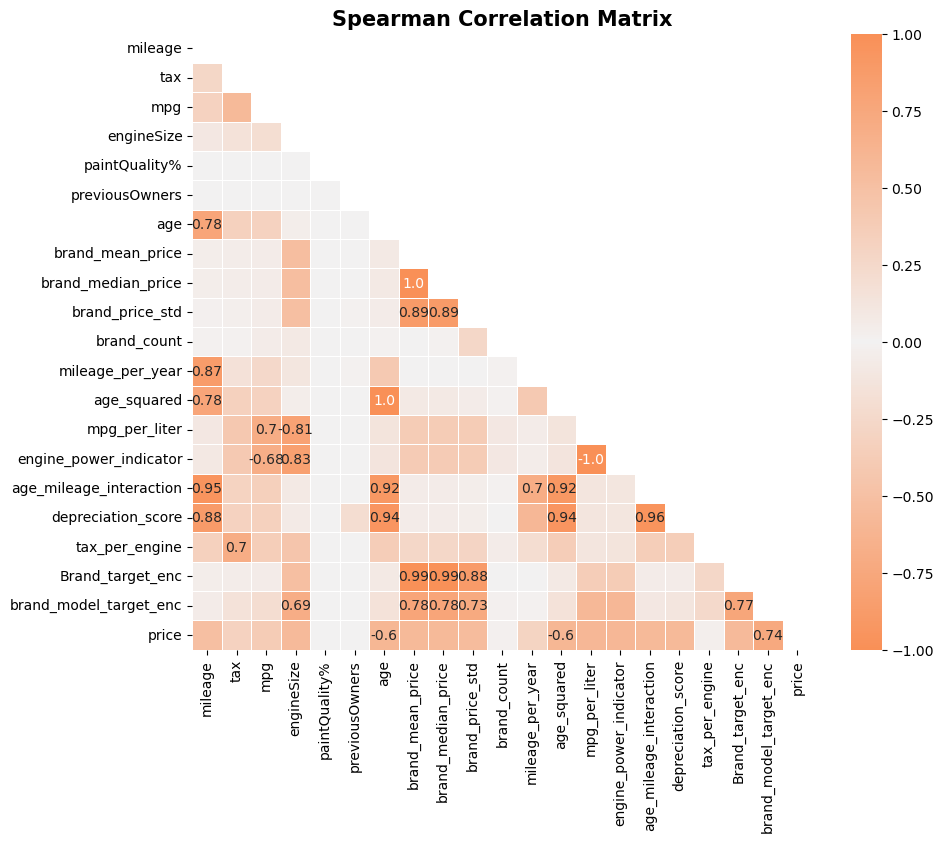

In [75]:
##### Spearman Correlation ####
cor = pd.concat([X_train_filtered, y_train], axis=1).corr(method='spearman').round(2)

# Create a custom diverging colormap based on orange tones
cmap = sns.diverging_palette(h_neg=30, h_pos=30, s=90, l=70, n=256, center="light", as_cmap=True) 

# Create a Mask to hide the upper triangle (to avoid redundancy)
mask = np.zeros_like(cor, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Only show values where absolute correlation is >= 0.6
mask_annot = np.absolute(cor.values) >= 0.6
annot = np.where(mask_annot, cor.values, np.full(cor.shape, ""))

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(
    data=cor,
    mask=mask,              # Hide the upper triangle
    cmap=cmap,              # Custom divergent color map
    annot=annot,            # Show annotations only if |value| >= 0.6
    fmt='s',                # Format annotations as strings
    vmin=-1, vmax=1, center=0, # Ensure the scale is from -1 to 1, centered at 0
    linewidths=0.5, 
)

plt.title('Spearman Correlation Matrix', fontsize=15, fontweight='bold')
plt.show()

By the rule of thumb, two variables are considered **redundant** when their absolute correlation is **greater than or equal to 0.8**. This is the case for **`mileage`** and **`miles_per_year`**, which is expected since `miles_per_year` was derived from `mileage`. We believe it would make more sense to **drop `mileage`**, as `miles_per_year` captures more information and `mileage` is also **highly correlated with `age`**, which could lead to **multicollinearity issues** if kept in the model, but we will **postpone this decision until the end of the feature selection stage**, after reviewing all method results.


In [76]:
target_col = y_train.name  # normalmente 'price'

# correlação de cada coluna com o target
cor_with_target = cor[target_col]

# features com |corr| < 0.1
low_corr_features = cor_with_target[cor_with_target.abs() < 0.1]

if not low_corr_features.empty:
    print(f"Found {len(low_corr_features)} variables with absolute correlation < 0.1 with {target_col}:")
    print(low_corr_features.abs().sort_values())
else:
    print(f"No variables found with absolute correlation < 0.1 with the target")

low_corr_to_drop = set(low_corr_features.index.tolist())


Found 4 variables with absolute correlation < 0.1 with price:
paintQuality%     0.00
previousOwners    0.00
brand_count       0.02
tax_per_engine    0.03
Name: price, dtype: float64


In [77]:
# só features (tudo menos o target)
feature_cols = [c for c in cor.columns if c != target_col]

# correlação absoluta entre features
corr_features = cor.loc[feature_cols, feature_cols].abs()

# parte superior da matriz para não repetir pares
upper = corr_features.where(np.triu(np.ones(corr_features.shape), k=1).astype(bool))

high_corr_threshold = 0.85  # ajusta se quiseres

high_corr_pairs = []
for col in upper.columns:
    for row, val in upper[col].dropna().items():
        if val > high_corr_threshold:
            high_corr_pairs.append((row, col, val))

print(f"\nFound {len(high_corr_pairs)} highly correlated feature pairs with |corr| > {high_corr_threshold}:")
for f1, f2, v in high_corr_pairs:
    print(f"  {f1}  <->  {f2}   (corr = {v:.2f})")

# decidir qual remover em cada par
high_corr_to_drop = set()

for f1, f2, v in high_corr_pairs:
    corr_f1_target = abs(cor.loc[f1, target_col])
    corr_f2_target = abs(cor.loc[f2, target_col])

    # 👉 manter a que tem MAIOR |corr| com o target
    # logo, deitamos fora a que tem MENOR |corr| com o target
    if corr_f1_target < corr_f2_target:
        high_corr_to_drop.add(f1)
    else:
        high_corr_to_drop.add(f2)

if high_corr_to_drop:
    print(f"\nBased on high inter-feature correlation, will drop {len(high_corr_to_drop)} features (keeping the one with higher |corr| to target):")
    for f in sorted(high_corr_to_drop):
        print("  -", f)
else:
    print("\nNo features to drop based on high inter-feature correlation.")



Found 16 highly correlated feature pairs with |corr| > 0.85:
  brand_mean_price  <->  brand_median_price   (corr = 1.00)
  brand_mean_price  <->  brand_price_std   (corr = 0.89)
  brand_median_price  <->  brand_price_std   (corr = 0.89)
  mileage  <->  mileage_per_year   (corr = 0.87)
  age  <->  age_squared   (corr = 1.00)
  mpg_per_liter  <->  engine_power_indicator   (corr = 1.00)
  mileage  <->  age_mileage_interaction   (corr = 0.95)
  age  <->  age_mileage_interaction   (corr = 0.92)
  age_squared  <->  age_mileage_interaction   (corr = 0.92)
  mileage  <->  depreciation_score   (corr = 0.88)
  age  <->  depreciation_score   (corr = 0.94)
  age_squared  <->  depreciation_score   (corr = 0.94)
  age_mileage_interaction  <->  depreciation_score   (corr = 0.96)
  brand_mean_price  <->  Brand_target_enc   (corr = 0.99)
  brand_median_price  <->  Brand_target_enc   (corr = 0.99)
  brand_price_std  <->  Brand_target_enc   (corr = 0.88)

Based on high inter-feature correlation, will dr

  estamos a criar a mesma variavei duas vezes miles_per_year  <->  mileage_per_year   (corr = 1.00)

In [78]:
features_to_drop = sorted(low_corr_to_drop | high_corr_to_drop)

print(f"\nTotal features to drop (low corr with target + high inter-feature corr): {len(features_to_drop)}")
print(features_to_drop)

X_train_clean = X_train.drop(columns=features_to_drop)
X_val_clean   = X_val.drop(columns=features_to_drop)
X_test_clean  = X_test.drop(columns=features_to_drop)

print("\nShapes after feature filtering:")
print("X_train_clean:", X_train_clean.shape)
print("X_val_clean:  ", X_val_clean.shape)
print("X_test_clean: ", X_test_clean.shape)



Total features to drop (low corr with target + high inter-feature corr): 13
['Brand_target_enc', 'age_mileage_interaction', 'age_squared', 'brand_count', 'brand_median_price', 'brand_price_std', 'depreciation_score', 'engine_power_indicator', 'mileage', 'mileage_per_year', 'paintQuality%', 'previousOwners', 'tax_per_engine']

Shapes after feature filtering:
X_train_clean: (60767, 21)
X_val_clean:   (15193, 21)
X_test_clean:  (32567, 21)


In [79]:
del X_train, X_val, X_test
X_train = X_train_clean.copy()
X_val = X_val_clean.copy()
X_test = X_test_clean.copy()

In [ ]:
# EVALUATION FUNCTION 
def evaluate_model(model, X_train, y_train, X_val, y_val):
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Calculate metrics
    scores = {
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Val MAE': mean_absolute_error(y_val, y_val_pred),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Val RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'Train Pinball (α=0.5)': mean_pinball_loss(y_train, y_train_pred, alpha=0.5),
        'Val Pinball (α=0.5)': mean_pinball_loss(y_val, y_val_pred, alpha=0.5)
    }
    return scores

# MODELS AND HYPERPARAMETER GRIDS
models_and_grids = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {} # Here we have no hyperparameters to tune
    },
    "ElasticNet": {
        "model": ElasticNet(random_state=37),
        "params": {
            'alpha': [0.1, 1.0, 10.0],   # Regularization strength
            'l1_ratio': [0.1, 0.5, 0.9]  # Mix between L1 and L2
        }
    },
    "Decision Tree": {
        "model": DecisionTreeRegressor(random_state=37),
        "params": {
            'max_depth': [5, 10, None], # Max depth to control overfitting
            'min_samples_leaf': [2, 5]  # Min samples per leaf
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=37, n_jobs=-1),
        "params": {
            'n_estimators': [100],      # Number of trees
            'max_depth': [10, 20],      # Max depth of trees
            'min_samples_leaf': [2, 4, 6] # Min samples per leaf
        }
    },
    "K-Neighbors": {
        "model": KNeighborsRegressor(n_jobs=-1),
        "params": {
            'n_neighbors': [3, 5, 7],   # Number of neighbors
            'weights': ['uniform', 'distance'] # Weight function
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(random_state=37),        
        "params": {
            'learning_rate': [0.1],
            'max_depth': [3,7],
            'min_samples_leaf': [3,5],
            'n_estimators': [200],
            'subsample': [1.0, 0.8]
        }
    },
    "SVR": {
        "model": SVR(),
        "params": {
            'kernel': ['rbf'],
            'C': [100, 1000],      # Regularization parameter
            'gamma': [ 'auto'] # Kernel coefficient
            #'C': [1, 10, 100],      # Regularization parameter
            #'gamma': ['scale', 'auto'] # Kernel coefficient
        }
    }
}


# MODEL TRAINING AND EVALUATION LOOP
results_list = []

# Iterate over each model defined in the dictionary
for model_name, config in models_and_grids.items():
    print(f"--- Processing model: {model_name} ---")
    param_grid = ParameterGrid(config['params'])
    best_model_results = None
    best_val_mae = float('inf')

    # Handle Linear Regression which has no grid
    if not list(param_grid):
        model = config['model']
        # Fit the model directly using X_train
        model.fit(X_train, y_train)
        scores = evaluate_model(model, X_train, y_train, X_val, y_val)
        best_model_results = {
            'Model': model_name,
            'Best Params': '{}',
            **scores
        }
    else:
        # Iterate over each combination of hyperparameters
        for params in param_grid:
            model = config['model']
            model.set_params(**params)
            
            # Fit the model directly using X_train
            model.fit(X_train, y_train)
            
            # Evaluate the model using the new evaluation function
            scores = evaluate_model(model, X_train, y_train, X_val, y_val)
            
            print(f"  Params: {params} -> Val MAE: {scores['Val MAE']:.4f}")
            
            # Store the best result based on validation MAE
            if scores['Val MAE'] < best_val_mae:
                best_val_mae = scores['Val MAE']
                best_model_results = {
                    'Model': model_name,
                    'Best Params': str(params),
                    **scores
                }
    
    results_list.append(best_model_results)
    print(f"Best validation MAE for {model_name}: {best_val_mae:.4f}\n")


# GET FINAL RESULTS
results_df = pd.DataFrame(results_list)

# Sort the results by validation MAE
results_df = results_df.sort_values(by='Val MAE', ascending=True)

# Reorder columns for better readability with the new metrics
columns_order = [
    'Model', 'Val MAE', 'Train MAE', 'Val RMSE', 'Train RMSE', 
    'Val Pinball (α=0.5)', 'Train Pinball (α=0.5)', 'Best Params'
]
results_df = results_df[columns_order]
display(results_df)

--- Processing model: Linear Regression ---
  Params: {} -> Val MAE: 2825.5438
Best validation MAE for Linear Regression: 2825.5438

--- Processing model: ElasticNet ---
  Params: {'alpha': 0.1, 'l1_ratio': 0.1} -> Val MAE: 2970.2882
  Params: {'alpha': 0.1, 'l1_ratio': 0.5} -> Val MAE: 2957.5027
  Params: {'alpha': 0.1, 'l1_ratio': 0.9} -> Val MAE: 2883.7543
  Params: {'alpha': 1.0, 'l1_ratio': 0.1} -> Val MAE: 3129.9550
  Params: {'alpha': 1.0, 'l1_ratio': 0.5} -> Val MAE: 3034.5477
  Params: {'alpha': 1.0, 'l1_ratio': 0.9} -> Val MAE: 2971.9478
  Params: {'alpha': 10.0, 'l1_ratio': 0.1} -> Val MAE: 5061.0420
  Params: {'alpha': 10.0, 'l1_ratio': 0.5} -> Val MAE: 4363.1508
  Params: {'alpha': 10.0, 'l1_ratio': 0.9} -> Val MAE: 3159.9558
Best validation MAE for ElasticNet: 2883.7543

--- Processing model: Decision Tree ---
  Params: {'max_depth': 5, 'min_samples_leaf': 2} -> Val MAE: 2794.5378
  Params: {'max_depth': 5, 'min_samples_leaf': 5} -> Val MAE: 2794.5378
  Params: {'max_dept

In [ ]:
#Combining training and validation datasets
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

print(f"Final training set dimensions (X): {X_train_full.shape}")
print(f"Final training set dimensions (y): {y_train_full.shape}")

# Train the Final Model with the Best Hyperparameters
best_params = {
    'learning_rate': 0.1,
    'max_depth': 7,
    'min_samples_leaf': 3,
    'n_estimators': 200,
    'subsample': 1.0,
    'random_state': 37  # Add a random_state for reproducible results
}

# Instantiate the GradientBoostingRegressor with the best parameters
final_model = GradientBoostingRegressor(**best_params)

# Train the model on the full combined dataset
final_model.fit(X_train_full, y_train_full)

# Make Predictions on the Test Set
test_predictions = final_model.predict(X_test)

# Create and Export the Submission File
print("Creating the submission file...")
submission_df = pd.DataFrame({
    'carID': X_test.index,
    'price': test_predictions
})

# Export to a CSV file without the DataFrame index
submission_df.to_csv("./project_data/Group37_Version5.csv", index=False)
print("\nSubmission file 'Group37_Version5.csv' exported successfully!")
print("First 5 rows of the submission file:")
print(submission_df.head())